# **Polynomial Regression with Cross-Validation**
----
----

This was made using the example Kaimi laid out [here.](https://kaimibk.github.io/blog/Intro_Data_Science/2019-09-25-Polynomial_Regression.html)

Polynomial regression is a form of classification aimed at deriving a generalized model.  Once our model correctly maps the current data, we can extend it to future data.  One major pitfall to watch out for is 'over-fitting.'

Models that over-fit data are not generalizable.  This is to say, that if your model fits the current data too well, it wont be able to accurately predict future data.  Such a model would not be useful for classifying data.

----

To practice polynomial regression, lets try to model the function:

$f(x) = 0.3x^3 - 2x^2 + 4x + 1.4$
<!--
$f(x) = 0.3 \cdot x^3 - 2 \cdot x^2 + 4 \cdot x + 1.4$
-->
<br>
Import the necessary library tools.

In [0]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE

To make our plots fancy and consistent.

In [0]:
# Just some default plotting style used later on
def restyle_fig(ax):
    ax.legend(loc="best")
    ax.grid(alpha=0.5)
    
    for spine in ax.spines.values():
        spine.set_visible(False)

STYLE_SHEET = "seaborn-notebook"

Define the (true) function we are trying to model.

In [0]:
def f(x):
  return (0.3 * x**3) - (2. * x**2) + (4 * x) + 1.4

Assuming our data was generated by a polynomial of degree N, from the model:

$y(x) = f(x) + \epsilon$

where $\epsilon \sim N(0, \sigma^2)$.  This means the values were sampled from a normal distribution, centered at 0, with variance $\sigma^2$.  The variance, $\sigma^2$ reflects our confidence, with regards to the data.  Adding $\epsilon$ to our original function, $f(x)$, generates artificial corruption in our data, $y(x)$.

Use 20 samples ($N=20$), uniformly distributed over the interval [0,3].  Introduce noice with a variance of 0.05 ($\sigma^2 = 0.05$).


In [0]:
# define sample size, N, and variance
N = 20
variance = 0.05

# set end points of interval
_left, _right = 0, 3

# N random samples from uniform distribution, on interval [0,3]
X = np.random.uniform(low=_left, high=_right, size=N)

# N random samples from normal distribution, on interval [0,3]
epsilon = np.random.normal(0, np.sqrt(variance), size=N)

# y is the signal, with noise (epsilon) added to our original function
y = f(X) + epsilon

plot_X = np.linspace(_left, _right, 100)

Plot the data and true model, to better visualize what is going on.

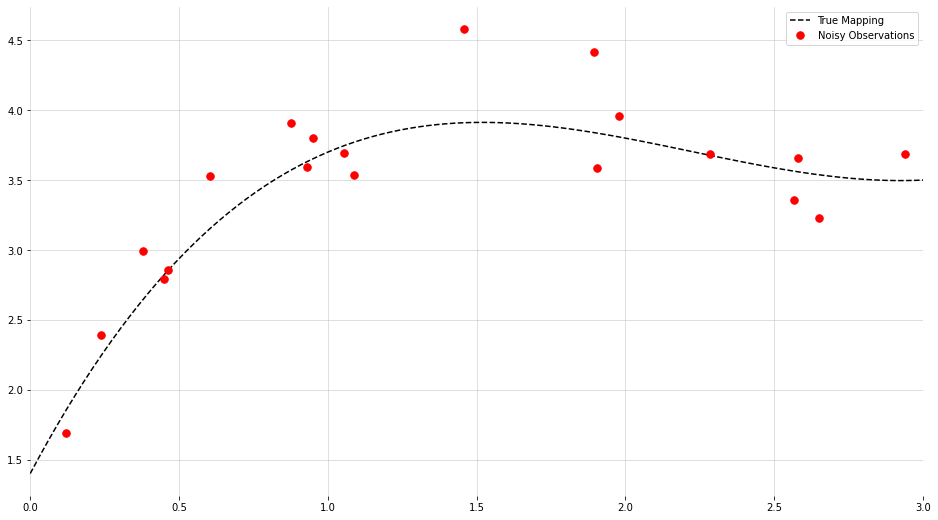

In [5]:
def plot_truef_noisydata():
	plt.style.context(STYLE_SHEET)
	
	# make figure
	fig = plt.figure(figsize=(16,9))
	ax = plt.gca()
	
	# plot true function and noisy data
	ax.plot(plot_X, f(plot_X), 'k--', label='True Mapping')
	ax.plot(X, y, 'r.', ms=15, label='Noisy Observations')
	
	ax.set_xlim(0,3)
	restyle_fig(ax)

plot_truef_noisydata()

Our true mapping, $f(x)$, is shown by the dashed black line.  Our noisy data are shown in red.

----
Polynomial regression determines the least squares relationship between the observed data and the 
[Vandermonde Matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix) 
of the observed data.  We will use the numpy function, 
[`np.vander`.](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.vander.html)
<br>
Note: similar results can be obtained using sklearn, `sklearn.preprocessing.PolynomialFeatures`

V is an $m \times n$ [Vandermonde Matrix,](https://en.wikipedia.org/wiki/Vandermonde_matrix) that expresses coefficients as $\alpha_i$ and polynomial values at each $\alpha_i$.

$$V = 
\begin{bmatrix} 
1 & \alpha_1 & \alpha_1^2 & \dots & \alpha_1^{n-1} \\
1 & \alpha_2 & \alpha_2^2 & \dots & \alpha_2^{n-1} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \alpha_m & \alpha_m^2 & \dots & \alpha_m^{n-1} \\
\end{bmatrix}
\quad
$$

In [6]:
# EX: Vandermonde Matrix 
np.vander(np.array([1,2,3]), 3)

array([[1, 1, 1],
       [4, 2, 1],
       [9, 3, 1]])

The line `np.vander(np.array([1,2,3]), 3)` takes our input array and generates a 
[Vandermonde Matrix,](https://en.wikipedia.org/wiki/Vandermonde_matrix)
(with a 3 column output).
<br>
$[1^2,~1^1,~1^0]$
<br>
$[2^2,~2^1,~2^0]$
<br>
$[3^2,~3^1,~3^0]$

----
### `scikit-learn` Models
Since `scikit-learn` doesn't offer a general polynomial regression, we need to build one using their framework.  Doing this allows us to use `scikit-learn`'s cross-validation framework.

Understand the object inheritance used in the following class:

In [0]:
class PolynomialRegression(BaseEstimator):
    def __init__(self, deg=1):
        self.deg = deg
    
    def fit(self, X, y, deg=None):
        self.model = LinearRegression(fit_intercept=False)
        self.model.fit(np.vander(X, N=self.deg + 1), y)
    
    def predict(self, x):
        return self.model.predict(np.vander(x, N=self.deg + 1))
    
    @property
    def coef_(self):
        return self.model.coef_

Since the `class PolynomialRegression()`, we just defined, depends on degree.  If we know the degree of the polynomial, everything is rather easy:

In [0]:
# 1. Initialize some model
known_degree_model = PolynomialRegression(deg=3)
# 2. Train the model on some data, X, and ouput, y
known_degree_model.fit(X, y)
# 3. Use that trained model to predict some other set of data
predict_y = known_degree_model.predict(plot_X)

Overlay the resulting polynomial on our previous plot.

Coefficients: [ 0.35874779 -2.35730507  4.56083476  1.31777584]


<Figure size 432x288 with 0 Axes>

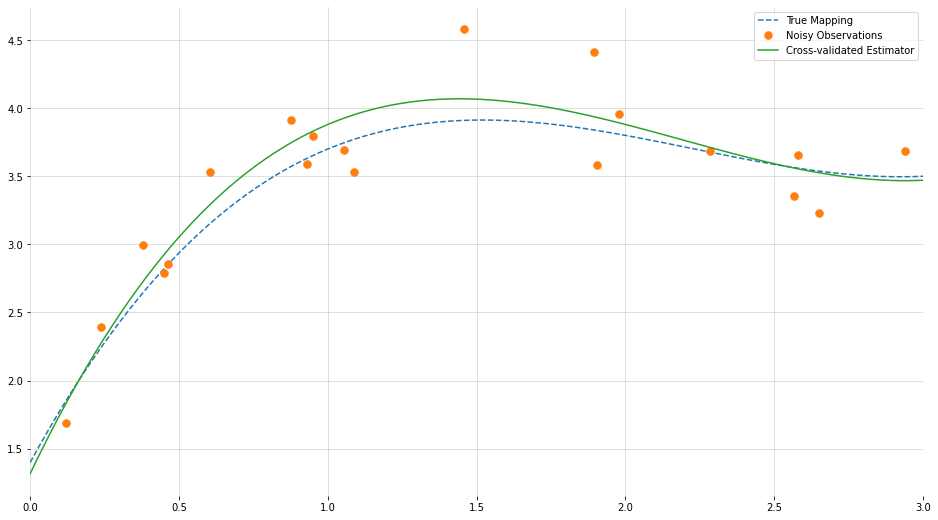

In [9]:
def makeplot_wCVest():
    #plt.clf()
    plt.style.context(STYLE_SHEET)
    fig = plt.figure(figsize=(16,9))
    ax = plt.gca()
    
    ax.plot(plot_X, f(plot_X), '--', label='True Mapping')
    ax.plot(X, y, '.', ms=15, label="Noisy Observations")
    ax.plot(plot_X, predict_y, label="Cross-validated Estimator")
    
    ax.set_xlim(0,3)
    
    restyle_fig(ax)
    print(f"Coefficients: {known_degree_model.coef_}")

plt.clf()
makeplot_wCVest()

We also told the code to spit out the coefficients of our resulting polynomial.
<br>
`Coefficients: [ 0.30141912 -1.99750872  4.03874371  1.37052378]`

----
### Polynomial of Unknown Degree and Overfitting

If we have a data set of size $N$, we can perfectly fit said data with a polynomial of degree $N-1$.  Doing so would be a case of overfitting.

To visualize this:

In [10]:
overfit_model = PolynomialRegression(deg=N-1)
overfit_model.fit(X, y)

#print(f"Coefficients: {overfit_model.coef_}")
print("Coefficients: ", overfit_model.coef_)
print("Number of Coefficients: ", len(overfit_model.coef_))

Coefficients:  [-1.19481212e+02  2.44381157e+03 -2.20669271e+04  1.14967821e+05
 -3.77147527e+05  7.87895279e+05 -9.68723627e+05  4.33733611e+05
  5.17296014e+05 -7.41417435e+05 -1.03251993e+05  7.66869323e+05
 -2.94617889e+05 -5.76708380e+05  8.22099934e+05 -5.04655873e+05
  1.74705751e+05 -3.48233313e+04  3.67888389e+03 -1.54204972e+02]
Number of Coefficients:  20


As said above, we have 20 coefficients ($N=20$).  This means we fit 19 degree polynomial ($N-1 = 20-1 = 19$).

Now, lets plot our `overfit_model` overlaid on our previous plot:

<Figure size 432x288 with 0 Axes>

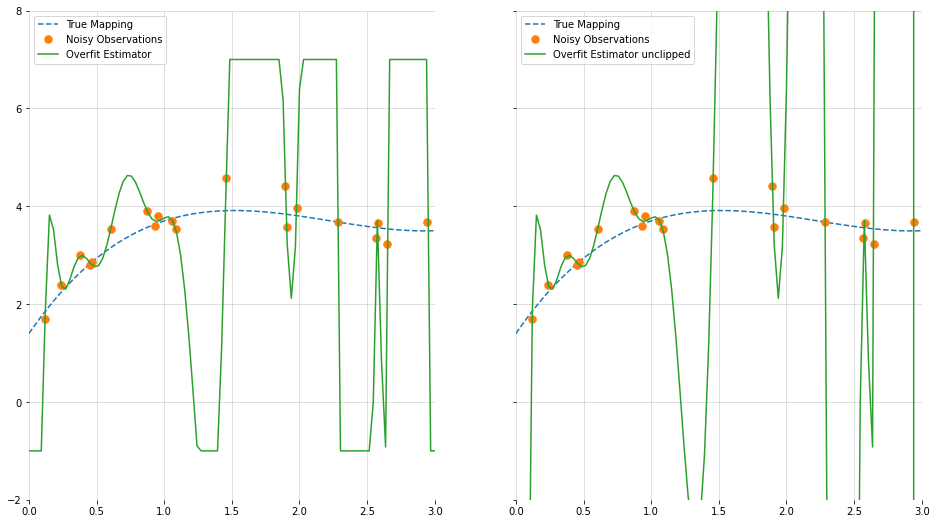

In [11]:
def plot_overlayed_w_overfit_model():
    plot_X = np.linspace(_left, _right, 100)

    plt.clf()
    fig, ax = plt.subplots(1,2, figsize=(16,9), sharey=True)
    plt.style.context(STYLE_SHEET)
    
    
    ax[0].plot(plot_X, f(plot_X), '--', label="True Mapping")
    ax[0].plot(X, y, '.', ms=15, label="Noisy Observations")
    ax[0].plot(plot_X, np.clip(overfit_model.predict(plot_X), -1, 7), label="Overfit Estimator")
    ax[0].set_ylim(-2,8)
    ax[0].set_xlim(0,3)
    ax[0].legend()
    restyle_fig(ax[0])

    
    ax[1].plot(plot_X, f(plot_X), '--', label="True Mapping")
    ax[1].plot(X, y, '.', ms=15, label="Noisy Observations")
    ax[1].plot(plot_X, overfit_model.predict(plot_X), label="Overfit Estimator unclipped")
    ax[1].set_xlim(0,3)
    ax[1].legend()
    restyle_fig(ax[1])

plot_overlayed_w_overfit_model()

In [12]:
print(f"MSE [Training]: {MSE(overfit_model.predict(X), y)}")

MSE [Training]: 0.0016319071782190768


We can see this model is overfit.  This means our model will not extend well to more general cases.  Any point not in our training set will not be predicted well by this model.

To show this, lets generate 10 more points (uniformly distributed in [0,3] interval) and apply our model to them.

In [0]:
N_predict = 10

predict_X = np.random.uniform(low=_left, high=_right, size= N_predict)
predict_eps = np.random.normal(0, np.sqrt(variance), size=N_predict)
predict_y = f(predict_X) + predict_eps

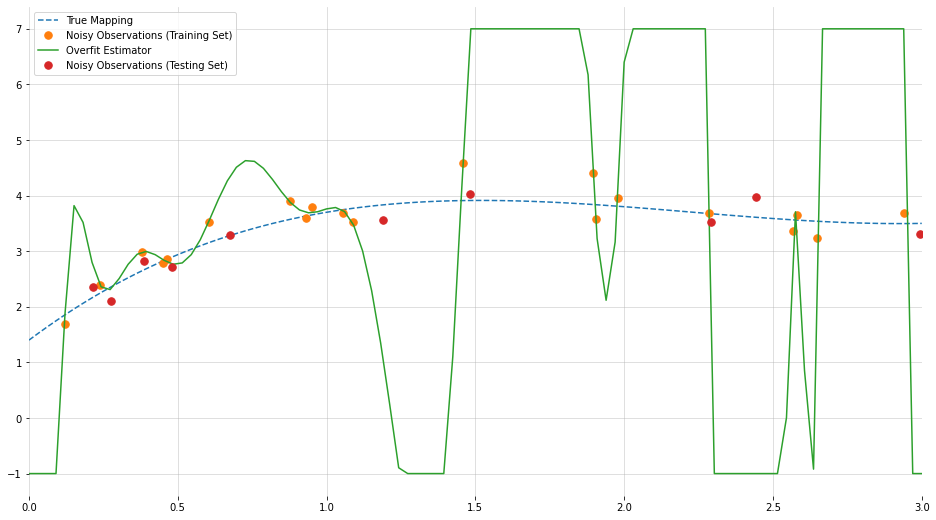

In [15]:
def plot_general_case():
  plt.style.context(STYLE_SHEET)
  plot_X = np.linspace(_left, _right, 100)
  
  fig = plt.figure(figsize=(16,9))
  ax = plt.gca()
  
  ax.plot(plot_X, f(plot_X), '--', label="True Mapping")
  ax.plot(X, y, '.', ms=15, label="Noisy Observations (Training Set)")
  ax.plot(plot_X, np.clip(overfit_model.predict(plot_X), -1, 7), label="Overfit Estimator")
  ax.plot(predict_X, predict_y, '.', ms=15, label="Noisy Observations (Testing Set)")
  
  ax.set_xlim(_left,_right)
  
  restyle_fig(ax)
plot_general_case()

Now check the MSE for the new set.

In [18]:
print(f"MSE [Testing]: {MSE(overfit_model.predict(predict_X), predict_y)}")

MSE [Testing]: 89568244.40401813


The new MSE is orders of magnitude higher than our previous value.  To prevent this, we will use a method called Cross Validation.

----
### K-Fold Cross Validation (k-fold CV)
Using k-fold CV allows or statistical model to be checked on unseen data.  Using unseen data allows us to determine how well the model is expected to perform on data not in the training set.

The 'k' in `k-fold` determines the number of groups our data will be split into.
<br>
ie. 3-fold validation is when $k=3$

**General Steps:**
1. Randomly shuffle data
2. Split data into 'k' groups
3. For each unique group:
  - Take group as test data set
  - Remaining data are training set
  - Fit model on training set and evaluate on test set
  - Keep evaluation score and get rid of model
4. Summarize skill of model using sample of model evaluation scores

Using a 3-fold CV, implement `scikit-learn`'s `GridSearchCV`:
```
from sklearn.model_selection import GridSearchCV
```

Our search is constrained to degrees between 1 and 25.  Here, our parameter space will be 1D and composed of the 'degrees' we are testing.

In [21]:
estimator = PolynomialRegression()
degrees = np.arange(1, 25)
cv_model = GridSearchCV(estimator, # model we wish to optimize
                        cv=3, # k-folds
                        param_grid={'deg': degrees}, # the parameter grid
                        scoring='neg_mean_squared_error')
cv_model.fit(X,y)

GridSearchCV(cv=3, error_score=nan, estimator=PolynomialRegression(deg=1),
             iid='deprecated', n_jobs=None,
             param_grid={'deg': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [25]:
GridSearchCV(cv=3, 
             error_score='raise-deprecating', 
             estimator=PolynomialRegression(deg=1), 
             iid='warn',
             n_jobs=None, 
             param_grid={'deg': np.arange(1,25)}, 
             pre_dispatch='2*n_jobs', 
             refit=True, 
             return_train_score=False, 
             scoring='neg_mean_squared_error', 
             verbose=0)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=PolynomialRegression(deg=1), iid='warn', n_jobs=None,
             param_grid={'deg': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

Check what CV has chosen and spit out coefficients.

In [26]:
print(f"Optimal Polynomial Degree: {cv_model.best_params_}")
print(f"Coefficients: {cv_model.best_estimator_.coef_}")

Optimal Polynomial Degree: {'deg': 3}
Coefficients: [ 0.35874779 -2.35730507  4.56083476  1.31777584]


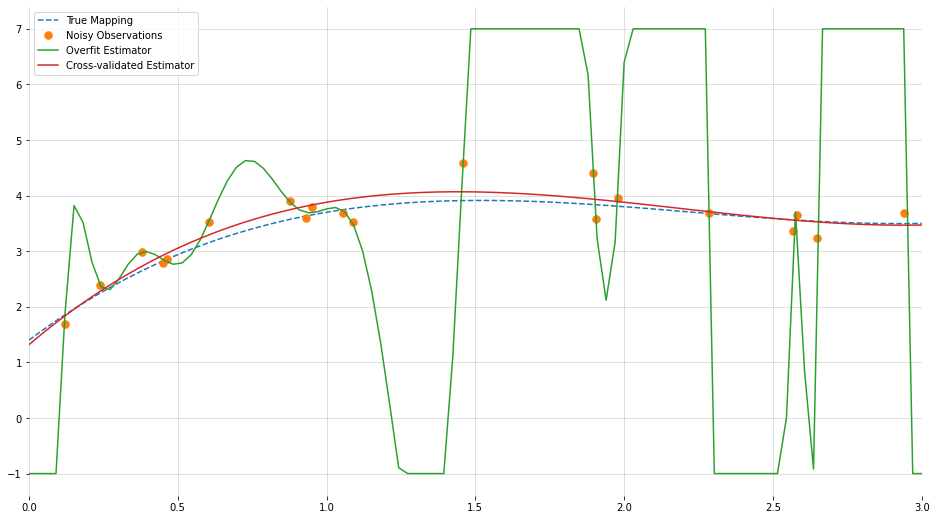

In [34]:
def plot_with_CVest():
    plt.style.context(STYLE_SHEET)
    fig = plt.figure(figsize=(16,9))
    ax = plt.gca()
    
    ax.plot(plot_X, f(plot_X), '--', label='True Mapping')
    ax.plot(X, y, '.', ms=15, label="Noisy Observations")
    ax.plot(plot_X, np.clip(overfit_model.predict(plot_X), -1, 7), label="Overfit Estimator")
    ax.plot(plot_X, cv_model.predict(plot_X), label="Cross-validated Estimator")
    
    ax.set_xlim(_left,_right)
    
    restyle_fig(ax)
plot_with_CVest()

This plot shows us a few things about the CV estimator:  it is smoother and much closer to our true polynomial, compared to our overfit estimator.  Now check the CV's MSE on training data:

In [30]:
print(f"MSE [Training]: {MSE(cv_model.predict(X), y)}")

MSE [Training]: 0.06504291106089401


Now check the CV's MSE on test data:

In [33]:
print(f"MSE [Testing]: {MSE(cv_model.predict(predict_X), predict_y)}")

MSE [Testing]: 0.06102728874273056


To really prove the advantages of CV, look at the following plot of -MSE vs fitted polynomial degree:

No handles with labels found to put in legend.


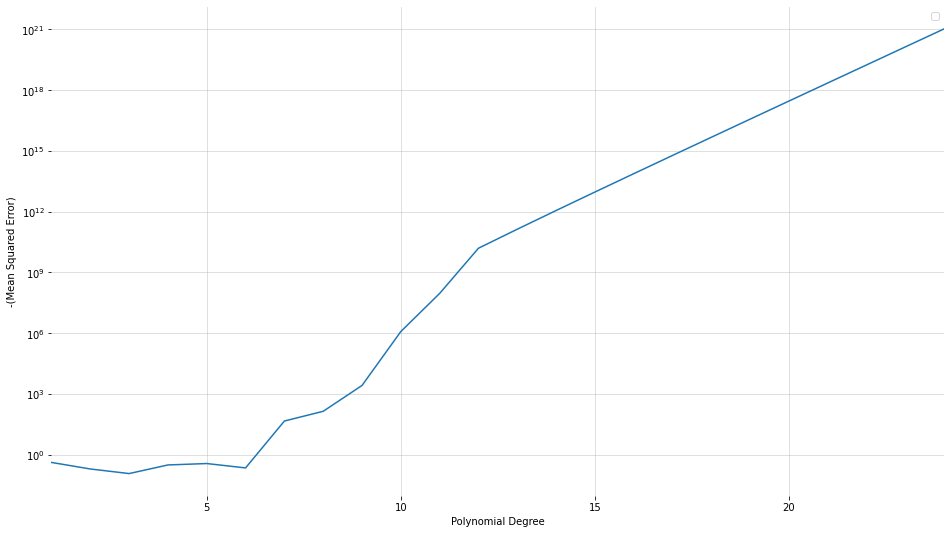

In [41]:
def plot_MSE_fitdegree():
    plt.style.context(STYLE_SHEET)
    fig = plt.figure(figsize=(16,9))
    ax = plt.gca()
    
    scores = np.array(cv_model.cv_results_['mean_test_score'])
    
    ax.errorbar(degrees, -scores)
    ax.set_yscale('log')
    ax.set_ylabel('-(Mean Squared Error)')
    ax.set_xlabel('Polynomial Degree')
    
    ax.set_xlim(1,24)
    
    restyle_fig(ax)

plot_MSE_fitdegree()

We want to look at where the -MSE score is minimized.